<a href="https://colab.research.google.com/github/gilvandrocesardemedeiros/Meteorology_replace-missing-values/blob/master/Replace_Missing_Values_Temperature%5BJoaoPessoa%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#Leitura de dados
dataSet = pd.read_csv("https://github.com/gilvandrocesardemedeiros/Meteorology_replace-missing-values/raw/master/DadosDiarios/joaopessoadiario.csv",
                      sep=';',skiprows=16)

In [0]:
#Transformando data em variável do tipo datetime
dataSet["Data"] = pd.to_datetime(dataSet["Data"], format = "%d/%m/%Y")

In [4]:
#Descrevendo base de dados
dataSet.describe()

,Estacao,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
count,26140.0,26140.000000,13063.000000,11917.000000,11199.000000,12257.000000,12318.000000,11155.000000,12143.000000,10529.000000,0.0
mean,82798.0,600.091813,5.152086,29.940715,23.769971,7.453613,4.253824,26.879996,75.929816,3.062547,NaN
std,0.0,600.011470,13.621993,1.266015,1.806049,3.012905,1.836179,1.312900,6.508173,0.861407,NaN
min,82798.0,0.000000,0.000000,23.400000,15.600000,0.000000,0.000000,21.680000,54.750000,0.000000,NaN
25%,82798.0,0.000000,0.000000,29.200000,22.400000,5.900000,3.000000,25.960000,71.250000,2.500000,NaN
50%,82798.0,1200.000000,0.200000,30.000000,23.800000,8.500000,4.000000,27.120000,74.500000,3.066667,NaN
75%,82798.0,1200.000000,3.800000,30.800000,25.100000,9.700000,5.200000,27.880000,79.250000,3.600000,NaN
max,82798.0,1200.000000,194.000000,33.600000,29.100000,11.700000,19.100000,30.340000,100.000000,7.566667,NaN


In [5]:
#Verificando dados
dataSet.head()

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
0,82798,1981-01-02,0,NaN,30.4,NaN,0.0,NaN,27.70,74.0,3.666667,NaN
1,82798,1981-01-02,1200,0.3,NaN,26.6,NaN,NaN,NaN,NaN,NaN,NaN
2,82798,1981-01-05,0,NaN,30.0,NaN,8.1,NaN,26.82,72.5,3.966667,NaN
3,82798,1981-01-05,1200,0.0,NaN,22.8,NaN,NaN,NaN,NaN,NaN,NaN
4,82798,1981-01-08,0,NaN,29.4,NaN,7.6,5.6,27.34,75.0,3.733333,NaN


In [0]:
#Atribuindo "Data" como índice para a base de dados
dataSet = dataSet.set_index("Data")

In [0]:
#Separando os dados em dois dataframes, um para as 00:00 h e outro para as 12:00 h
dataSet00, dataSet12 = dataSet[dataSet["Hora"] == 0], dataSet[dataSet["Hora"] == 1200]

In [0]:
#Descartando as colunas "Hora", "Estacao" e "Unnamed: 11" 
dataSet00, dataSet12 = dataSet00.drop(columns = ["Hora", "Estacao", "Unnamed: 11"]), dataSet12.drop(columns = ["Hora", "Estacao", "Unnamed: 11"])

In [9]:
#Verificando dataframe para os dados disponibilizados às 00:00 h
dataSet00.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,0.0,11917.000000,0.0,12257.000000,12318.000000,11155.000000,12143.000000,10529.000000
mean,NaN,29.940715,NaN,7.453613,4.253824,26.879996,75.929816,3.062547
std,NaN,1.266015,NaN,3.012905,1.836179,1.312900,6.508173,0.861407
min,NaN,23.400000,NaN,0.000000,0.000000,21.680000,54.750000,0.000000
25%,NaN,29.200000,NaN,5.900000,3.000000,25.960000,71.250000,2.500000
50%,NaN,30.000000,NaN,8.500000,4.000000,27.120000,74.500000,3.066667
75%,NaN,30.800000,NaN,9.700000,5.200000,27.880000,79.250000,3.600000
max,NaN,33.600000,NaN,11.700000,19.100000,30.340000,100.000000,7.566667


In [10]:
#Verificando dataframe para os dados disponibilizados às 12:00 h
dataSet12.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,13063.000000,0.0,11199.000000,0.0,0.0,0.0,0.0,0.0
mean,5.152086,NaN,23.769971,NaN,NaN,NaN,NaN,NaN
std,13.621993,NaN,1.806049,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,15.600000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,NaN,22.400000,NaN,NaN,NaN,NaN,NaN
50%,0.200000,NaN,23.800000,NaN,NaN,NaN,NaN,NaN
75%,3.800000,NaN,25.100000,NaN,NaN,NaN,NaN,NaN
max,194.000000,NaN,29.100000,NaN,NaN,NaN,NaN,NaN


In [0]:
#Eliminando colunas completas por "NaN" em cada uma das bases de dados
dataSet00 = dataSet00.drop(columns = ["Precipitacao","TempMinima"])
dataSet12 = dataSet12.drop(columns = ["TempMaxima","Insolacao","Evaporacao Piche","Temp Comp Media","Umidade Relativa Media","Velocidade do Vento Media"])

In [12]:
#Exibindo a base de dados recém filtrada para 00:00 h
dataSet00.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
Data,,,,,,
1981-01-02,30.4,0.0,NaN,27.70,74.00,3.666667
1981-01-05,30.0,8.1,NaN,26.82,72.50,3.966667
1981-01-08,29.4,7.6,5.6,27.34,75.00,3.733333
1981-01-09,30.2,10.6,5.4,27.66,70.75,4.433333
1981-01-10,30.4,10.0,6.4,27.74,72.50,4.133333


In [13]:
#Exibindo a base de dados recém filtrada para 12:00 h
dataSet12.head()

,Precipitacao,TempMinima
Data,,
1981-01-02,0.3,26.6
1981-01-05,0.0,22.8
1981-01-08,2.2,26.2
1981-01-09,0.0,26.0
1981-01-10,0.0,25.4


In [0]:
#Criando o intervalo completo de tempo de 01-01-1980 à 31-12-2017
dataInicial = '1980-01-01'
dataFinal = '2017-12-31'
tempo = pd.date_range(dataInicial, dataFinal)
#Atribuindo este intervalo de tempo à um dataSet provisório
dataSetProv = pd.DataFrame()
dataSetProv["Data"] = tempo

In [0]:
#Atribuindo o índice para o dataSet provisório como sendo a coluna de datas
dataSetProv = dataSetProv.set_index("Data")

In [16]:
#Visualizando o dataSet provisório
dataSetProv.head()

""
Data
1980-01-01
1980-01-02
1980-01-03
1980-01-04
1980-01-05


In [0]:
#Mesclando o dataSet provisório como sendo o resultado da junção dos dataSet00 e dataSet12
dataSetProv = dataSetProv.join(dataSet00).join(dataSet12)

In [18]:
#Mostrando o resultado da junção
dataSetProv.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#Quantidade de dias existentes na base de dados
len(dataSetProv)

13880

In [0]:
#Tornando o dataSet como sendo o dataSet provisório
dataSet = dataSetProv

In [21]:
#Descrevendo o novo dataSet
dataSet.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,11917.000000,12257.000000,12318.000000,11155.000000,12143.000000,10529.000000,13063.000000,11199.000000
mean,29.940715,7.453613,4.253824,26.879996,75.929816,3.062547,5.152086,23.769971
std,1.266015,3.012905,1.836179,1.312900,6.508173,0.861407,13.621993,1.806049
min,23.400000,0.000000,0.000000,21.680000,54.750000,0.000000,0.000000,15.600000
25%,29.200000,5.900000,3.000000,25.960000,71.250000,2.500000,0.000000,22.400000
50%,30.000000,8.500000,4.000000,27.120000,74.500000,3.066667,0.200000,23.800000
75%,30.800000,9.700000,5.200000,27.880000,79.250000,3.600000,3.800000,25.100000
max,33.600000,11.700000,19.100000,30.340000,100.000000,7.566667,194.000000,29.100000


In [22]:
#Mostrando o cabeçalho do novo dataSet
dataSet.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Modelagem para previsão de Temperatura Máxima

In [0]:
#Separando base de dados para treino de rede neural para previsão de temperatura máxima
dataTreinoTempMax = dataSet.dropna(subset = ["TempMaxima"])

In [0]:
#Separando a variável que será prevista, TempMaxima, da base de dados
tempMax = dataTreinoTempMax["TempMaxima"]
dataTreinoTempMax = dataTreinoTempMax.drop(columns = "TempMaxima")

In [25]:
#Visualizando cabeçalho dos dados para treino
dataTreinoTempMax.head()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,
1981-01-02,0.0,NaN,27.70,74.00,3.666667,0.3,26.6
1981-01-05,8.1,NaN,26.82,72.50,3.966667,0.0,22.8
1981-01-08,7.6,5.6,27.34,75.00,3.733333,2.2,26.2
1981-01-09,10.6,5.4,27.66,70.75,4.433333,0.0,26.0
1981-01-10,10.0,6.4,27.74,72.50,4.133333,0.0,25.4


In [26]:
#Visualizando cabeçalho das informações de temperatura 
tempMax.head()

Data
1981-01-02    30.4
1981-01-05    30.0
1981-01-08    29.4
1981-01-09    30.2
1981-01-10    30.4
Name: TempMaxima, dtype: float64

In [0]:
#Guardando a informação de como as colunas estão distribuídas no dataFrame
colunas = dataTreinoTempMax.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMax = mms.fit_transform(dataTreinoTempMax)

In [29]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMax)
prov.columns = colunas
prov.describe()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,11124.000000,11232.000000,11151.000000,11534.000000,10007.000000,11906.000000,11177.000000
mean,0.272978,-0.562415,0.201104,-0.064365,-0.193582,-0.947756,0.210812
std,0.515099,0.189635,0.303065,0.286222,0.224622,0.138859,0.267526
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.008547,-0.685864,-0.011547,-0.270718,-0.339207,-1.000000,0.007407
50%,0.452991,-0.581152,0.256351,-0.127072,-0.198238,-0.997938,0.214815
75%,0.658120,-0.465969,0.431871,0.082873,-0.052863,-0.961856,0.407407
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0 
dataTreinoTempMax = np.nan_to_num(dataTreinoTempMax, copy = False)

In [31]:
#Verificando dimensões do dataSet
print(dataTreinoTempMax.shape)

(11917, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMax, X_testTempMax, Y_trainTempMax, Y_testTempMax = train_test_split(dataTreinoTempMax, tempMax, test_size = 0.1, random_state = 9)

In [0]:
#Definindo uma função para criar a MLP
def trainMLP(optimizer='adam', init='random_uniform', units = 7, camadas = 2):    
  #Criando o modelo
  mlp = Sequential()
  #Adicionando a camada de entrada
  mlp.add(Dense(activation = 'tanh', input_dim = units, units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando as camadas escondidas
  for i in range(camadas):
    mlp.add(Dense(activation = 'tanh', units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando a camada de saída
  mlp.add(Dense(units = 1, kernel_initializer = init, bias_initializer='zeros'))    
  # Compilando o modelo
  mlp.compile(loss='mean_squared_error', optimizer = optimizer, metrics= ['mae'])
  return mlp

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMax = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [38]:
#Busca pelos melhores parâmetros
grid_resultTempMax = grid_searchTempMax.fit(X_trainTempMax, Y_trainTempMax)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 1s - loss: 670.1489 - mean_absolute_error: 25.7557
Epoch 2/200
 - 1s - loss: 378.4376 - mean_absolute_error: 19.3438
Epoch 3/200
 - 1s - loss: 202.5696 - mean_absolute_error: 14.1078
Epoch 4/200
 - 1s - loss: 95.0669 - mean_absolute_error: 9.5927
Epoch 5/200
 - 1s - loss: 36.6838 - mean_absolute_error: 5.8452
Epoch 6/200
 - 1s - loss: 11.0043 - mean_absolute_error: 3.0407
Epoch 7/200
 - 1s - loss: 3.0819 - mean_absolute_error: 1.4786
Epoch 8/200
 - 1s - loss: 1.6870 - mean_absolute_error: 1.0343
Epoch 9/200
 - 1s - loss: 1.5817 - mean_absolute_error: 0.9780
Epoch 10/200
 - 1s - loss: 1.5799 - mean_absolute_error: 0.9737
Epoch 11/200
 - 1s - loss:

In [39]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMax.best_score_, grid_resultTempMax.best_params_))
means = grid_resultTempMax.cv_results_['mean_test_score']
stds = grid_resultTempMax.cv_results_['std_test_score']
params = grid_resultTempMax.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -0.350624, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-0.350624 (0.009788) {'batch_size': 10, 'camadas': 2, 'units': 7}


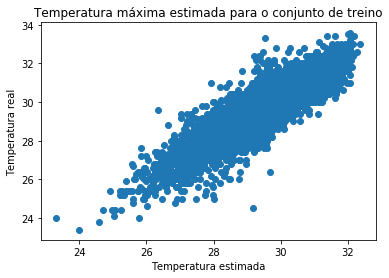

In [40]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax)
plt.title("Temperatura máxima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [41]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax))

[[1.         0.89360509]
 [0.89360509 1.        ]]


In [0]:
#Previsão com base no resultado da Grid Search
Y_predTempMax = grid_searchTempMax.predict(X_testTempMax)

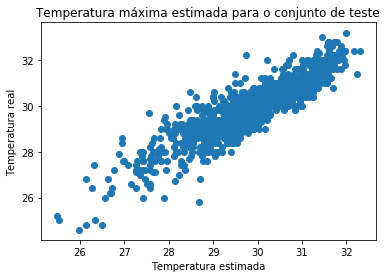

In [43]:
#Gráfico que mostra a relação entre a temperatura máxima real e a prevista para o conjunto de teste
plt.scatter(Y_predTempMax, Y_testTempMax)
plt.title("Temperatura máxima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [44]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMax, Y_testTempMax))

[[1.         0.89785959]
 [0.89785959 1.        ]]


In [45]:
#Erro absoluto médio entre a temperatura máxima prevista e a real
print(mean_absolute_error(Y_testTempMax, Y_predTempMax))

0.4230336243674259


In [46]:
#Erro quadrático médio entre a temperatura máxima prevista e a real
print(mean_squared_error(Y_testTempMax, Y_predTempMax))

0.30883888643334306


# Modelagem para previsão de Temperatura Mínima

In [0]:
#Separando dados para treinar rede neural para previsão de temperatura mínima
dataTreinoTempMin = dataSet.dropna(subset = ["TempMinima"])

In [0]:
#Separando a variável que será prevista, TempMinima, da base de dados
tempMin = dataTreinoTempMin["TempMinima"]
dataTreinoTempMin = dataTreinoTempMin.drop(columns = "TempMinima")

In [49]:
#Visualizando dados de treino para temperatura mínima
dataTreinoTempMin.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
Data,,,,,,,
1981-01-02,30.4,0.0,NaN,27.70,74.00,3.666667,0.3
1981-01-05,30.0,8.1,NaN,26.82,72.50,3.966667,0.0
1981-01-08,29.4,7.6,5.6,27.34,75.00,3.733333,2.2
1981-01-09,30.2,10.6,5.4,27.66,70.75,4.433333,0.0
1981-01-10,30.4,10.0,6.4,27.74,72.50,4.133333,0.0


In [50]:
#Visualizando informações de temperatura mínima para cada um dos dados de treino 
tempMin.head()

Data
1981-01-02    26.6
1981-01-05    22.8
1981-01-08    26.2
1981-01-09    26.0
1981-01-10    25.4
Name: TempMinima, dtype: float64

In [0]:
#Guardando informação de como as colunas estão distribuídas no dataFrame 
colunas = dataTreinoTempMin.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMin = mms.fit_transform(dataTreinoTempMin)

In [53]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMin)
prov.columns = colunas
prov.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
count,11177.000000,10417.000000,10520.000000,11127.000000,10850.000000,9732.000000,11190.000000
mean,0.286555,0.275618,-0.569760,0.201165,-0.064114,-0.194367,-0.949241
std,0.248724,0.512941,0.183260,0.303125,0.286654,0.223089,0.135861
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.137255,0.025641,-0.685864,-0.011547,-0.270718,-0.339207,-1.000000
50%,0.294118,0.452991,-0.581152,0.256351,-0.127072,-0.198238,-0.997938
75%,0.450980,0.658120,-0.476440,0.431871,0.082873,-0.057269,-0.962887
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0
dataTreinoTempMin = np.nan_to_num(dataTreinoTempMin, copy = False)

In [55]:
#Verificando dimensões do dataSet
print(dataTreinoTempMin.shape)

(11199, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMin, X_testTempMin, Y_trainTempMin, Y_testTempMin = train_test_split(dataTreinoTempMin, tempMin, test_size = 0.1, random_state = 9)

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMin = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [61]:
#Busca pelos melhores parâmetros
grid_resultTempMin = grid_searchTempMin.fit(X_trainTempMin, Y_trainTempMin)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Epoch 1/200
 - 1s - loss: 400.8330 - mean_absolute_error: 19.8213
Epoch 2/200
 - 1s - loss: 198.7065 - mean_absolute_error: 13.9027
Epoch 3/200
 - 1s - loss: 91.2461 - mean_absolute_error: 9.2941
Epoch 4/200
 - 1s - loss: 35.4543 - mean_absolute_error: 5.6038
Epoch 5/200
 - 1s - loss: 11.7302 - mean_absolute_error: 2.9415
Epoch 6/200
 - 1s - loss: 4.6150 - mean_absolute_error: 1.7561
Epoch 7/200
 - 1s - loss: 3.3745 - mean_absolute_error: 1.5265
Epoch 8/200
 - 1s - loss: 3.2740 - mean_absolute_error: 1.5066
Epoch 9/200
 - 1s - loss: 3.2677 - mean_absolute_error: 1.5051
Epoch 10/200
 - 1s - loss: 3.2828 - mean_absolute_error: 1.5061
Epoch 11/200
 - 1s - loss: 3.2697 - mean_absolute_error: 1.5052
Epoch 12/200
 - 1s - loss: 3.2703 - mean_absolute_error: 1.5051
Epoch 13/200
 - 1s - 

In [62]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMin.best_score_, grid_resultTempMin.best_params_))
means = grid_resultTempMin.cv_results_['mean_test_score']
stds = grid_resultTempMin.cv_results_['std_test_score']
params = grid_resultTempMin.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -0.827902, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-0.827902 (0.031516) {'batch_size': 10, 'camadas': 2, 'units': 7}


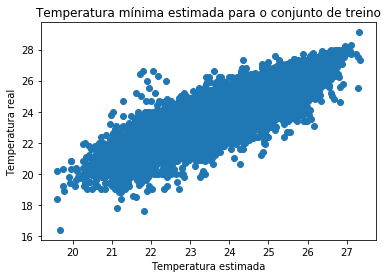

In [63]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin)
plt.title("Temperatura mínima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [64]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin))

[[1.         0.87065617]
 [0.87065617 1.        ]]


In [0]:
#Previsão para os dados de teste a partir da modelagem obtida
Y_predTempMin = grid_searchTempMin.predict(X_testTempMin)

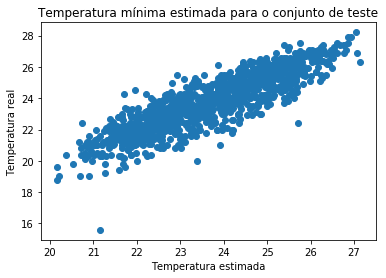

In [66]:
#Gráfico que mostra a relação entre a temperatura mínima real e a temperatura mínima prevista para os dados de teste
plt.scatter(Y_predTempMin, Y_testTempMin)
plt.title("Temperatura mínima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [67]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMin, Y_testTempMin))

[[1.         0.87678874]
 [0.87678874 1.        ]]


In [68]:
#Erro absoluto médio entre temperatura mínima real e prevista para os dados de teste
print(mean_absolute_error(Y_testTempMin, Y_predTempMin))

0.715161749976022


In [69]:
#Erro quadrático médio entre a temperatura mínima real e a prevista para os dados de teste
print(mean_squared_error(Y_testTempMin, Y_predTempMin))

0.7978042086224736


In [70]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pickle
# Salvando os modelos treinados
filename = '/content/gdrive/My Drive/TemperaturaMaximaJoaoPessoa.sav'
pickle.dump(grid_searchTempMax, open(filename, 'wb'))

In [0]:
filename = '/content/gdrive/My Drive/TemperaturaMinimaJoaoPessoa.sav'
pickle.dump(grid_searchTempMin, open(filename, 'wb'))